Code adapted from TensorFlow's "Image captioning with visual attention" article, specifically the "A Transformer decoder model section.
https://www.tensorflow.org/text/tutorials/image_captioning#a_transformer_decoder_model

In [13]:
import importlib
import json

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.optimizers import Adam
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap

import utils.dataset
importlib.reload(utils.dataset)

from utils.model import TokenOutput, Captioner, GenerateText, SeqEmbedding, CausalSelfAttention, CrossAttention, FeedForward, DecoderLayer, standardize
from utils.dataset import setup_trainval_sets, load_dataset, load_image, setup_test_set

In [5]:
np.random.seed(42)
tf.random.set_seed(42)

In [6]:
# Constants for notebook
TRAIN_DATASET_PATH = "./processed_dataset/train2014_full"
TRAIN_ANNOTATIONS_PATH = "dataset/annotations_trainval2014/captions_train2014.json"
TEST_ANNOTATIONS_PATH = "dataset/annotations_test2014/image_info_test2014.json"

BATCH_SIZE = 256
VOCABULARY_SIZE = 10000
IMAGE_SHAPE = (224, 224, 3)

In [7]:
coco_train = COCO(TRAIN_ANNOTATIONS_PATH)
coco_test = COCO(TEST_ANNOTATIONS_PATH)

loading annotations into memory...
Done (t=0.73s)
creating index...
index created!
loading annotations into memory...
Done (t=0.11s)
creating index...
index created!


In [5]:
train_raw = setup_trainval_sets("train2014", coco_train)

I0000 00:00:1737939304.720814     884 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21770 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


In [6]:
test_raw = setup_test_set(coco_test)

In [7]:
for img_path, caption in train_raw.take(1):
    print("Image path:", img_path.numpy())
    print("Caption:", caption.numpy())

Image path: b'dataset/train2014/COCO_train2014_000000057870.jpg'
Caption: b'A restaurant has modern wooden tables and chairs.'


2025-01-27 01:55:08.666761: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
for img_id, img_path  in test_raw.take(1):
    print("Image path:", img_id.numpy())
    print("Caption:", img_path.numpy())

Image path: 523573
Caption: b'dataset/test2014/COCO_test2014_000000523573.jpg'


2025-01-27 01:55:12.090739: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
mobilenet = MobileNetV3Small(
    input_shape=IMAGE_SHAPE,
    include_top=False, # Exclude the classification head
    weights='imagenet',
    pooling=None,
)

mobilenet.trainable=False

In [10]:
tokenizer = TextVectorization(
  max_tokens=VOCABULARY_SIZE,
  standardize=standardize,
  output_sequence_length=50,
  ragged=True
)

In [11]:
tokenizer.adapt(train_raw.map(lambda img_path, caption: caption).batch(1024))

In [12]:
tokenizer.get_vocabulary()[:10]

['',
 '[UNK]',
 np.str_('a'),
 np.str_('[START]'),
 np.str_('[END]'),
 np.str_('on'),
 np.str_('of'),
 np.str_('the'),
 np.str_('in'),
 np.str_('with')]

In [13]:
t = tokenizer([['a large wooden cat'], ['a table on a hill']])

In [14]:
t

<tf.RaggedTensor [[3, 2, 29, 99, 51, 4], [3, 2, 24, 5, 2, 224, 4]]>

In [15]:
# Setting up data for training
train_ds = load_dataset(TRAIN_DATASET_PATH)

In [16]:
# Sanity check for data loading
train_ds.element_spec

for (inputs, end_token) in train_ds.take(1):
  (img, start_token) = inputs

print(img.shape)
print(start_token.shape)
print(end_token.shape)

print(start_token[0])
print(end_token[0])
print(img[0])

(256, 7, 7, 576)
(256, 22)
(256, 22)
tf.Tensor(
[  3   2 633 272 117  58   9   2 873   0   0   0   0   0   0   0   0   0
   0   0   0   0], shape=(22,), dtype=int64)
tf.Tensor(
[  2 633 272 117  58   9   2 873   4   0   0   0   0   0   0   0   0   0
   0   0   0   0], shape=(22,), dtype=int64)
tf.Tensor(
[[[-2.35861585e-01 -0.00000000e+00  2.88518882e+00 ... -0.00000000e+00
    3.71150875e+00 -0.00000000e+00]
  [ 2.72211909e+00 -0.00000000e+00 -0.00000000e+00 ... -0.00000000e+00
    3.00443935e+00 -0.00000000e+00]
  [ 9.36598778e+00 -0.00000000e+00  6.09354615e-01 ... -0.00000000e+00
    1.00399280e+00 -0.00000000e+00]
  ...
  [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 ... -0.00000000e+00
   -3.64820182e-01 -0.00000000e+00]
  [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 ... -0.00000000e+00
   -0.00000000e+00 -0.00000000e+00]
  [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 ... -0.00000000e+00
   -0.00000000e+00 -0.00000000e+00]]

 [[-0.00000000e+00 -0.00000000e+00  2.795090

2025-01-27 01:56:17.028570: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [17]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

100%|██████████| 1618/1618 [11:09<00:00,  2.42it/s]


Uniform entropy: 9.21
Marginal entropy: 5.41


In [18]:
def masked_loss(labels, preds):
    labels = tf.cast(labels, tf.int32)  # Ensure labels are integers (otherwise you get an error)
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

    mask = (labels != 0) & (loss < 1e8) 
    mask = tf.cast(mask, loss.dtype)

    loss = loss*mask
    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss


def masked_acc(labels, preds):
    mask = tf.cast(labels!=0, tf.float32)
    preds = tf.argmax(preds, axis=-1)
    labels = tf.cast(labels, tf.int64)
    match = tf.cast(preds == labels, mask.dtype)
    acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
    return acc

In [19]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
image = load_image(image_path, IMAGE_SHAPE)

In [22]:
loaded_model = Captioner(
    tokenizer, 
    feature_extractor=mobilenet, 
    output_layer=output_layer,
    units=256, 
    dropout_rate=0.2, 
    num_layers=2, 
    num_heads=2
)

loaded_model.compile(optimizer=Adam(learning_rate=0.001), loss=masked_loss, metrics=[masked_acc])

input_shape = ((None, 7, 7, 576), (None, None))  # Example input shapes
loaded_model.build(input_shape)

/home/hylke/miniconda3/envs/imagecaption/lib/python3.10/site-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'captioner_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


### I have no idea why, but you need to load in the weights in this order, otherwise it doesn't work: Cell 26, Cell 31, Cell 26 again and Cell 31 again.

In [25]:
loaded_model.load_weights("trained_model/checkpoint_weights.weights.h5")

### Temperature Parameter Modes

The `temperature` parameter allows you to interpolate between three modes:

1. **Greedy Decoding** (`temperature = 0.0`):  
   Chooses the most likely next token at each step.

2. **Random Sampling According to the Logits** (`temperature = 1.0`):  
   Samples tokens based on the predicted probabilities.

3. **Uniform Random Sampling** (`temperature >> 1.0`):  
   Performs nearly uniform sampling, reducing the influence of the model's predictions.

[source](https://www.tensorflow.org/text/tutorials/image_captioning#generate_captions)

In [26]:
for t in (0.0, 0.5, 1.0, 2.0):
  loaded_result = loaded_model.simple_gen(image, temperature=t)
  print(f"Loadimgimgmmasded_model.result, t={t}: ", loaded_result)
  print("--------")

Loadimgimgmmasded_model.result, t=0.0:  a surfer is riding a wave in the ocean
--------
Loadimgimgmmasded_model.result, t=0.5:  a man riding a wave in the ocean
--------
Loadimgimgmmasded_model.result, t=1.0:  a surfer in the air while riding in the air
--------
Loadimgimgmmasded_model.result, t=2.0:  there escorting reigns copy fron fall median roosters vw fountain grips struggling hides far brush necks dispenser white cake scrolling on hardware fastened skyscrapers spire rides kite briefly excitedly focal fashion catches plain beautiful taking after picture kitchen dvd bicyclist behind he skiies present perching rotted falcon chairs around
--------


In [39]:
def generate_captions_and_save_to_json(dataset, model, temperature, output_file):
    captions = []

    for img_id, img_path in dataset:
        img_id = img_id.numpy()
        img_path = img_path.numpy().decode("utf-8")
        img = load_image(img_path, IMAGE_SHAPE)

        caption = model.simple_gen(img, temperature)
        captions.append({"image_id": int(img_id), "caption": caption})

    with open(output_file, "w") as f:
        json.dump(captions, f, indent=4)

    print(f"Captions saved to {output_file}")

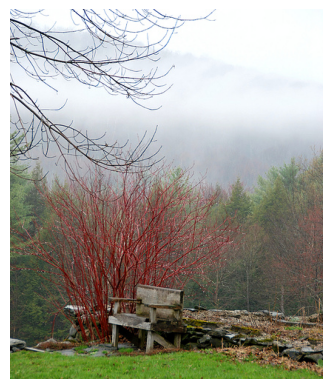

In [34]:
file_name = "COCO_test2014_000000523573.jpg"
img_path = f"dataset/test2014/{file_name}"
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()

In [28]:
image_test = load_image("dataset/test2014/COCO_test2014_000000523573.jpg", IMAGE_SHAPE)

In [36]:
loaded_model.simple_gen(image_test, temperature=0.5)

'the cows are grazing the grass near a tree'

In [40]:
generate_captions_and_save_to_json(test_raw, loaded_model, 0.5, "captions_test2014_results_temperature_05.json")

Captions saved to captions_test2014_results_temperature_05.json


### Model Evaluation

In [45]:
coco_test = COCO(TEST_ANNOTATIONS_PATH)

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


In [46]:
TEST_CAPTIONS_RESULTS_FILE = "captions_test2014_results_temperature_05.json"

In [47]:
coco_test_res = coco_test.loadRes(TEST_CAPTIONS_RESULTS_FILE)

Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!


In [48]:
coco_test_eval = COCOEvalCap(coco_test, coco_test_res)

In [49]:
coco_test.getImgIds()

[523573,
 347527,
 413171,
 102283,
 296903,
 540552,
 327534,
 159467,
 509990,
 252230,
 104129,
 133861,
 247972,
 434451,
 200433,
 21611,
 426258,
 545307,
 8301,
 401222,
 98637,
 437561,
 497278,
 158661,
 301576,
 539885,
 493588,
 568780,
 189456,
 44731,
 93529,
 29665,
 507184,
 343911,
 525078,
 364546,
 531756,
 478790,
 71426,
 497944,
 162826,
 541546,
 208149,
 552653,
 202227,
 463410,
 539629,
 571087,
 514526,
 65046,
 396465,
 161484,
 143768,
 156165,
 238464,
 30943,
 151665,
 185192,
 360854,
 101203,
 24865,
 569204,
 132534,
 35231,
 125542,
 515033,
 141459,
 326687,
 425232,
 531251,
 537883,
 146108,
 37409,
 15516,
 143451,
 258801,
 86936,
 148352,
 349422,
 112317,
 78277,
 381883,
 355468,
 61657,
 13601,
 387611,
 368351,
 91354,
 424892,
 285572,
 223351,
 98148,
 92357,
 463871,
 546087,
 352666,
 302697,
 490925,
 98254,
 482547,
 89377,
 362930,
 109109,
 84601,
 316378,
 347294,
 81671,
 206163,
 340232,
 568900,
 557592,
 16163,
 565156,
 523798,


In [50]:
def compare_image_ids(json_file_path, reference_array):
    try:
        with open(json_file_path, 'r') as file:
            data = json.load(file)
        
        extracted_ids = [item['image_id'] for item in data]
        
        return extracted_ids == reference_array
    
    except (FileNotFoundError, json.JSONDecodeError, KeyError) as e:
        print(f"An error occurred: {e}")
        return False

In [51]:
compare_image_ids(TEST_CAPTIONS_RESULTS_FILE, coco_test.getImgIds())

True

In [55]:
# Does not work on Python 3, must be done on Python 2.7

coco_test_eval.evaluate()

tokenization...


PTBTokenizer tokenized 0 tokens at 0.00 tokens per second.
PTBTokenizer tokenized 437422 tokens at 3157057.33 tokens per second.


setting up scorers...
computing Bleu score...


AssertionError: 